In [17]:
import torch 
import torch.nn as nn 
from torch.nn import functional as F
torch.manual_seed(163173)

In [60]:
with open("input.txt", 'r', encoding='utf-8') as f:
    text = f.read()
    
chars = sorted(list(set(text)))
vocab_size=len(chars)
print(''.join(chars))
print(vocab_size)

itos = {i:char for i,char in enumerate(chars)}
stoi = {char:i for i, char in enumerate(chars)}
encode = lambda x: [stoi[char] for char in list(x)]
decode = lambda x: ''.join([itos[num] for num in list(x)])

print(encode('poor'), decode(encode("poor")))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
[54, 53, 53, 56] poor


In [19]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)

n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

torch.Size([1115394]) torch.int64


In [61]:
batch_size = 4
block_size = 8

def get_batch(split):
    data = train_data if split=="train" else val_data
    ix = torch.randint(len(data)-block_size, (batch_size,))
    x = torch.stack([data[i:block_size+i]for i in ix])
    y = torch.stack([data[i+1:block_size+i+1] for i in ix])
    return x, y 


## -----------------------------------------------------------------------------------------------

In [21]:
n_embed = 32

In [1]:
class Head(nn.Module):
    def __init__(self, head_size ):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
    def forward(self, x):
        B, T, C = x.shape()
        k = self.key(x)
        q = self.query(x)
        
        wei = q @ k.transpose(-2, -1) * head_size**-0.5
        
        wei = wei.masked_fill(self.tril[:T, :T]==0, float("-inf"))
        wei = F.softmax(wei, dim=-1)
        
        v = self.value(x)

        out = wei @ v
        
        return out 


class MultiHeadAttention(nn.Module):
    
        def __init__(self, num_heads, head_size):
            super().__init__()
            self.heads = nn.ModuleList([Head(head_size) for _ in range (num_heads)])
        
        def forward(self, x):
            return torch.cat([h(x) for h in self.heads], dim=-1)

NameError: name 'nn' is not defined

In [63]:
class BigramLanguaugeModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.l_head = nn.Linear(n_embed, vocab_size)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.sa_head = MultiHeadAttention(4, n_embed//4)
        
    def forward(self, idx, targets):
        
        B, T = idx.shape
        
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T))
        x = tok_emb + pos_emb
        x = self.sa_head(x)
        logits = self.l_head(x)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
            
        return logits, loss
    
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            
            idx_con = idx[:, -block_size:]
            
            logits, loss = self(idx_con)
            
            probs = F.softmax(logits, dim=-1)  
            
            idx_next = torch.multinomial(probs, num_samples=1)
            
            idx = torch.cat((idx, idx_next), dim=1)
            
        return idx


model = BigramLanguaugeModel()


# -----------------------------------------------------------------------------------

In [38]:
B ,T ,C = 4 ,8 ,32
x = torch.randn(B, T, C)

## Easiest attention block 

### Single head of attention

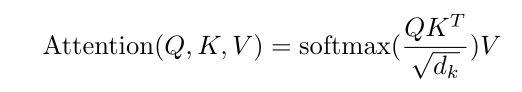

In [50]:
head_size = 16 

key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)
q = query(x)

wei = q @ k.transpose(-2, -1) * head_size**-0.5

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=-1)

v = value(x)

out = wei @ v

In [ ]:
optimizer = torch.optim.AdamW()